In [1]:
import os
os.chdir("..")
assert 'PromptDataExtract' in os.getcwd()

In [2]:
# Load settings
from backend import sett, postgres
sett.load_settings()
postgres.load_settings()

Load OK: settings.yaml


In [3]:
# Connect to database
db = postgres.connect('polylet')

      -- postgres_ SSH tunnel established.
NOTE  -- postgres_ Connected to PostGres DB: polylet (took 0.090 s)


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

try:
    plt.style.use("~/matplotlib.mplstyle")
except: pass

In [23]:
def execute(sql, **kwargs) -> pd.DataFrame:
    """ Query the database using raw sql.
        Return a pandas dataframe containing the results.
    """
    results = postgres.raw_sql(sql, kwargs)
    if not results:
        return None
    return pd.DataFrame.from_records(results, columns=results[0]._fields)

In [43]:
def plot_venn_diagram(A, B, label_a, label_b, title="", saveas=None):
    A = set(A)
    B = set(B)
    a_not_b = len(A - B)
    b_not_a = len(B - A)
    a_and_b = len(A & B)
    total = a_not_b + b_not_a + a_and_b

    fig, ax = plt.subplots(1, 1, figsize=(3.25, 3))
    v = venn2(subsets=(a_not_b, b_not_a, a_and_b), set_labels=(label_a, label_b), ax=ax)
    for p in v.patches:
        p.set_linewidth(1)
        p.set_edgecolor('k')

    v.get_label_by_id('10').set_text(f"{100 * a_not_b / total : 0.2f} %")
    v.get_label_by_id('01').set_text(f"{100 * b_not_a / total : 0.2f} %")
    v.get_label_by_id('11').set_text(f"{100 * a_and_b / total : 0.2f} %")
    title += f"\nTotal: {total :,}"

    ax.set(title = title)
    plt.tight_layout()
    if saveas:
        plt.savefig(saveas, dpi=300)
    plt.show()

In [30]:
gpt_methods = [
    180, 175, 202, 179, 194, 200, 190, 176, 191, 186, 198, 196, 193, 188, 199,
    184, 182, 189, 187, 181, 178, 197, 177, 195, 183, 201, 192, 185, 231, 232,
]

# Paragraphs

In [33]:
# Create a set of all paragraphs where GPT extracted data
gpt_paras = []

for mid in gpt_methods:
    print(mid, end=' ')
    rows = postgres.raw_sql("""
        SELECT pt.id FROM extracted_materials em 
        JOIN paper_texts pt ON pt.id = em.para_id
        WHERE em.method_id = :mid;
    """, mid=mid)
    for r in rows:
        gpt_paras.append(r.id)

print("\nDone. Total paras =", len(gpt_paras))

180 175 202 179 194 200 190 176 191 186 198 196 193 188 199 184 182 189 187 181 178 197 177 195 183 201 192 185 231 232 
Done. Total paras = 380755


In [34]:
# Create a set of all paragraphs where MaterialsBERT extracted data
mtb_paras = []

rows = postgres.raw_sql("""
    SELECT pt.id FROM extracted_materials em 
    JOIN paper_texts pt ON pt.id = em.para_id
    WHERE em.method_id = :mid;
""", mid = 1)
for r in rows:
    mtb_paras.append(r.id)

print("\nDone. Total paras =", len(mtb_paras))


Done. Total paras = 1607662


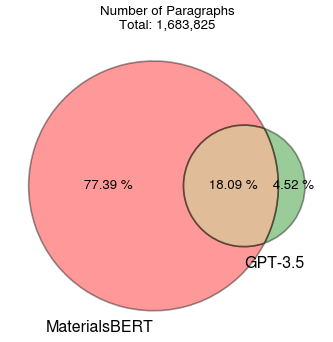

In [42]:
plot_venn_diagram(mtb_paras, gpt_paras, label_a='MaterialsBERT', label_b='GPT-3.5',
    title="Number of Paragraphs"
)

# Materials

In [47]:
# Create a set of all paragraphs where GPT extracted data
gpt_mats = []

for mid in gpt_methods:
    print(mid, end=' ')
    rows = postgres.raw_sql("""
        SELECT em.entity_name as name FROM extracted_materials em 
        WHERE em.method_id = :mid;
    """, mid=mid)
    for r in rows:
        gpt_mats.append(r.name)

print("\nDone. Total materials =", len(gpt_mats))

180 175 202 179 194 200 190 176 191 186 198 196 193 188 199 184 182 189 187 181 178 197 177 195 183 201 192 185 231 232 
Done. Total materials = 866104


In [48]:
# Create a set of all paragraphs where MaterialsBERT extracted data
mtb_mats = []

rows = postgres.raw_sql("""
    SELECT em.entity_name as name FROM extracted_materials em 
    WHERE em.method_id = :mid;
""", mid = 1)
for r in rows:
    mtb_mats.append(r.name)

print("Done. Total materials =", len(mtb_mats))

Done. Total materials = 2623085


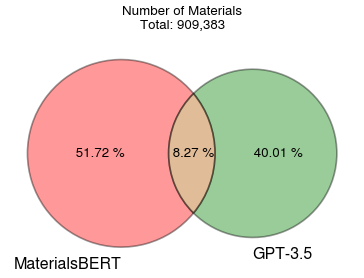

In [49]:
plot_venn_diagram(mtb_mats, gpt_mats, label_a='MaterialsBERT', label_b='GPT-3.5',
    title="Number of Materials"
)